In [3]:
%%capture
%run naive_algorithm.ipynb
%run features_engineering.ipynb

In [2]:
import random 
import seaborn as sns
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from sklearn.preprocessing import StandardScaler

## Split Train/Test

Probleme de segments dans lequel sont compris d'autres segments , pour eviter de la fuite de données dans le cas ou
segment se retrouverais dans le train et une partie de celui ci dans le train : 

* Calcul de jour calendaire/année de chaque segment
* Selection au hasard de certaines dates qui constitueront le test_set , tout le reste dans le train_set
* De cette maniere aucun segment réalisé a une meme date ne pourra se retrouver a la fois dans le train et le test


In [4]:
segments_df.head(5)

,id,activity_id,athlete_id,name,elapsed_time,moving_time,distance,average_cadence,average_watts,average_grade,...,climb_category,average_heart_rate,max_heart_rate,start_time,start_date,time_activities_last_30d,type_virtualride,time_virtual_last_30d,time_real_last_30d,days_since_last_activity
0,24674235,4831255939,10944546,Champs-Élysées,653,653,6623.10,82.3,202.8,0.0,...,0,161.2,170.0,18:46:25,2021-02-22,315.25,1,213.85,101.4,0
1,27141377,4831057316,10944546,Epic KOM - Start to Bypass Intersection (Zwift...,424,424,1882.50,77.3,201.2,3.8,...,0,157.9,164.0,18:19:40,2021-02-22,315.25,1,213.85,101.4,2
2,22501195,4818094466,10944546,Villenave-Technopole,789,789,5100.50,NaN,108.0,0.5,...,0,169.0,184.0,14:39:32,2021-02-20,262.78,0,262.78,0.0,3
3,3566434,4818094466,10944546,Col du Chateau d'eau,217,217,1190.37,NaN,141.8,2.1,...,0,170.7,183.0,14:40:47,2021-02-20,262.78,0,262.78,0.0,3
4,20598228,4818094466,10944546,Col du chateau d'eau court,151,151,745.40,NaN,165.4,2.8,...,0,177.5,183.0,14:42:02,2021-02-20,262.78,0,262.78,0.0,3


In [5]:
calendar_days = []
for date in segments_df['start_date']:
    calendar_day = date.strftime('%j%Y')
    calendar_days.append(calendar_day)

segments_df['calendar_day'] = calendar_days

In [6]:
dates = segments_df['calendar_day'].unique()

In [7]:
dates = dates.tolist()

In [8]:
ratio_train_test = len(dates) * 0.2
ratio_train_test

40.0

In [9]:
random.seed(42)
dates_test_set = random.sample(dates,int(ratio_train_test))

In [10]:
test_set = segments_df[segments_df['calendar_day'].isin(dates_test_set)]
test_set.shape

(379, 22)

In [11]:
test_set_index = test_set.index
test_set_index

Int64Index([   2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
            ...
            1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886],
           dtype='int64', length=379)

In [12]:
train_set = segments_df.drop(test_set_index)
train_set

,id,activity_id,athlete_id,name,elapsed_time,moving_time,distance,average_cadence,average_watts,average_grade,...,average_heart_rate,max_heart_rate,start_time,start_date,time_activities_last_30d,type_virtualride,time_virtual_last_30d,time_real_last_30d,days_since_last_activity,calendar_day
0,24674235,4831255939,10944546,Champs-Élysées,653,653,6623.100,82.3,202.8,0.0,...,161.2,170.0,18:46:25,2021-02-22,315.25,1,213.85,101.4,0,0532021
1,27141377,4831057316,10944546,Epic KOM - Start to Bypass Intersection (Zwift...,424,424,1882.500,77.3,201.2,3.8,...,157.9,164.0,18:19:40,2021-02-22,315.25,1,213.85,101.4,2,0532021
27,27180136,4801436758,10944546,Kent Rd Climb to Sprint Banner (Zwift Insider ...,176,176,1137.300,81.4,183.4,2.6,...,149.4,156.0,13:36:00,2021-02-17,254.98,1,254.98,0.0,5,0482021
28,21748007,4801436758,10944546,Yorkshire Sprint Reverse,63,63,394.300,79.9,182.9,2.1,...,153.4,156.0,13:37:53,2021-02-17,254.98,1,254.98,0.0,5,0482021
29,27207377,4801436758,10944546,Finishing Straightaway (Zwift Insider verified),99,99,611.100,78.4,192.3,3.3,...,156.7,162.0,13:40:47,2021-02-17,254.98,1,254.98,0.0,5,0482021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1935,17782861,1597380847,10944546,RadarStadeMartillac,40,40,303.400,NaN,189.4,1.4,...,176.8,182.0,12:42:52,2018-05-26,0.00,0,0.00,0.0,0,1462018
1936,3654728,1597380847,10944546,Faux plat chemin de Rochemorin,90,90,541.374,NaN,158.9,2.0,...,183.6,188.0,12:47:30,2018-05-26,0.00,0,0.00,0.0,0,1462018
1937,3752963,1597380847,10944546,Imitationberg,141,141,872.000,NaN,82.3,-0.0,...,168.2,184.0,12:53:34,2018-05-26,0.00,0,0.00,0.0,0,1462018
1938,14775448,1597380847,10944546,Château Vignau - Chemin de Couhins,226,226,1431.800,NaN,84.4,-0.6,...,155.2,186.0,12:56:14,2018-05-26,0.00,0,0.00,0.0,0,1462018


In [13]:
1561/1940

0.804639175257732

## Model

In [14]:
columns = ['elapsed_time','distance','average_grade','climb_category','time_activities_last_30d','type_virtualride','time_virtual_last_30d','time_real_last_30d','days_since_last_activity']
corrmat = train_set[columns].corr()
corrmat

,elapsed_time,distance,average_grade,climb_category,time_activities_last_30d,type_virtualride,time_virtual_last_30d,time_real_last_30d,days_since_last_activity
elapsed_time,1.000000,0.867961,0.179051,0.861286,-0.071526,0.296199,0.011322,-0.163704,-0.037132
distance,0.867961,1.000000,-0.100558,0.582509,-0.018262,0.230796,0.055301,-0.143515,-0.031812
average_grade,0.179051,-0.100558,1.000000,0.342676,0.105908,0.534938,0.198791,-0.175962,-0.161513
climb_category,0.861286,0.582509,0.342676,1.000000,-0.090750,0.334232,-0.010541,-0.159363,-0.037436
time_activities_last_30d,-0.071526,-0.018262,0.105908,-0.090750,1.000000,0.190333,0.870202,0.292599,-0.398828
type_virtualride,0.296199,0.230796,0.534938,0.334232,0.190333,1.000000,0.401503,-0.402101,-0.268455
time_virtual_last_30d,0.011322,0.055301,0.198791,-0.010541,0.870202,0.401503,1.000000,-0.216512,-0.338177
time_real_last_30d,-0.163704,-0.143515,-0.175962,-0.159363,0.292599,-0.402101,-0.216512,1.000000,-0.133940
days_since_last_activity,-0.037132,-0.031812,-0.161513,-0.037436,-0.398828,-0.268455,-0.338177,-0.133940,1.000000


In [15]:
columns = ['elapsed_time','distance','climb_category','type_virtualride','time_activities_last_30d','days_since_last_activity']
# columns = ['elapsed_time','distance','average_grade']
train_set = train_set[columns]
test_set = test_set[columns]

In [16]:
y_train = train_set["elapsed_time"]
X_train = train_set.drop("elapsed_time", axis=1)
y_test  = test_set["elapsed_time"]
X_test = test_set.drop("elapsed_time", axis=1)


print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(1561,)
(1561, 5)
(379,)
(379, 5)


**Log Label**

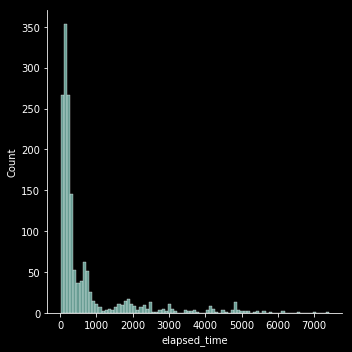

In [17]:
sns.displot(y_train)

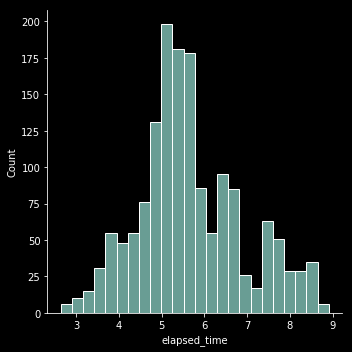

In [18]:
sns.displot(np.log(y_train))

In [19]:
y_train_log = np.log(y_train)

## Scaler ##

In [20]:
# standard_scaler = StandardScaler()

In [21]:
# standard_scaler.fit(X_train)

In [22]:
# X_train_scaled = standard_scaler.transform(X_train)
# X_test_scaled = standard_scaler.transform(X_test)

#### Algos

In [23]:
reg = LinearRegression()
reg.fit(X_train,y_train_log)
y_pred_reg_log = reg.predict(X_test)

In [24]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train,y_train_log)
y_pred_xgb_log = xgb_reg.predict(X_test)

In [25]:
mae_reg = mean_absolute_error(y_test,np.exp(y_pred_reg_log))
mape_reg = mean_absolute_percentage_error(y_test, np.exp(y_pred_reg_log))
rmse_reg  = np.sqrt(mean_squared_error(y_test,np.exp(y_pred_reg_log)))
print(f'mae_reg : {mae_reg}')
print(f'mape_reg : {mape_reg}')
print(f'rmse_reg: {rmse_reg}')

mae_reg : 288.80073349138706
mape_reg : 0.881158461389754
rmse_reg: 745.5009391790985


In [26]:
mae_xgb = mean_absolute_error(y_test,np.exp(y_pred_xgb_log))
mape_xgb = mean_absolute_percentage_error(y_test, np.exp(y_pred_xgb_log))
rmse_xgb  = np.sqrt(mean_squared_error(y_test,np.exp(y_pred_xgb_log)))
print(f'mae_xgb : {mae_xgb}')
print(f'mape_xgb: {mape_xgb}')
print(f'rmse_xgb: {rmse_xgb}')

mae_xgb : 81.31783219692261
mape_xgb: 0.19888328278221765
rmse_xgb: 148.66860915847778


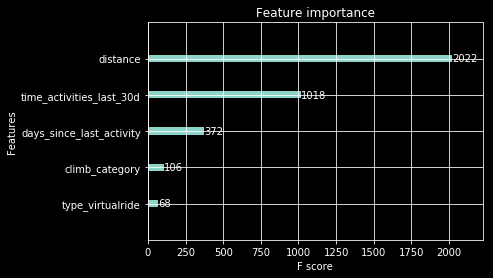

In [27]:
xgb.plot_importance(xgb_reg)
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

In [28]:
data = {
    'MAE':[mae_naive,mae_reg,mae_xgb],
    'MAPE':[mape_naive,mape_reg,mape_xgb],
    'RMSE':[rmse_naive,rmse_reg,rmse_xgb]
}

comparaison_df = pd.DataFrame(data, index=['naive','linreg','xgbreg'])
comparaison_df.sort_values(by=['MAPE'])

,MAE,MAPE,RMSE
xgbreg,81.317832,0.198883,148.668609
naive,202.259702,0.372339,464.705005
linreg,288.800733,0.881158,745.500939


### 50 biggests Errors Pred XGB

In [29]:
test_set['pred'] = np.exp(y_pred_xgb_log)
test_set['error_pred'] = abs(test_set['pred'] - test_set['elapsed_time'])
biggest_errors = test_set.sort_values(by=['error_pred'], ascending=False).head(50)

In [30]:
segments_df.loc[biggest_errors.index]

,id,activity_id,athlete_id,name,elapsed_time,moving_time,distance,average_cadence,average_watts,average_grade,...,average_heart_rate,max_heart_rate,start_time,start_date,time_activities_last_30d,type_virtualride,time_virtual_last_30d,time_real_last_30d,days_since_last_activity,calendar_day
644,24690956,3898407306,10944546,Roule Ma Poule,2790,2790,23034.800,81.2,167.9,0.0,...,NaN,NaN,18:50:50,2020-08-11,1119.85,1,918.68,201.17,1,2242020
551,18397725,4022259796,10944546,2018 UCI Worlds Course Short Lap,4126,4126,23654.000,84.7,150.2,0.0,...,NaN,NaN,18:46:26,2020-09-06,1480.12,1,1480.12,0.00,1,2502020
550,18358841,4022259796,10944546,Zwift Worlds Course Forward,4126,4126,23655.200,84.7,150.2,0.0,...,NaN,NaN,18:46:26,2020-09-06,1480.12,1,1480.12,0.00,1,2502020
1595,26074884,2414179938,10944546,À fond jusqu'au poteau,733,79,523.100,NaN,23.6,2.6,...,139.9,173.0,13:50:48,2019-06-01,694.68,0,486.55,208.13,2,1522019
552,18397965,4022259796,10944546,Innsbruck KOM,2541,2541,7430.400,82.0,145.4,5.4,...,NaN,NaN,18:53:32,2020-09-06,1480.12,1,1480.12,0.00,1,2502020
1596,3480183,2414179938,10944546,Arrivée course de Villenave Chambéry,644,46,225.740,NaN,230.8,5.6,...,150.5,160.0,13:52:17,2019-06-01,694.68,0,486.55,208.13,2,1522019
515,16784833,4055624217,10944546,Epic KOM,2286,2244,9410.500,84.1,172.0,3.9,...,NaN,NaN,19:19:03,2020-09-13,1536.03,1,1536.03,0.00,1,2572020
1867,18635320,1610209983,10944546,Saint-Magne > Peyron,2500,2500,16431.600,NaN,84.5,-0.1,...,147.3,164.0,16:07:16,2018-06-01,226.13,0,0.00,226.13,3,1522018
1857,8132163,1610209983,10944546,Piste Cabanac-et-Villagrains/Hostens,2414,2414,16727.300,NaN,100.7,0.1,...,140.2,161.0,15:03:01,2018-06-01,226.13,0,0.00,226.13,3,1522018
1446,22501185,2526015396,10944546,Technopole- Villenave d'Ornon,1117,677,5127.700,NaN,99.0,-0.5,...,163.5,186.0,18:03:03,2019-07-12,589.78,0,260.35,329.43,1,1932019


### Prediction Alpe d'huez

In [31]:
query = {
    "query": {
        "match": {
            "_id": 2787335981548134218
        }
    }
}

result = database.search(
    index="index_route",
    size=1000,
    body= query
)

route_alpe = result['hits']['hits'][0]['_source']
segments_alpe = route_alpe.get("segmentation")
segments_alpe_df = pd.DataFrame(segments_alpe)
segments_alpe_df

,distance,altitude_gain,average_grade,all_points
0,270.55,-0.80,-0.30,"[[45.05476, 6.031770000000001], [45.0547500000..."
1,422.22,4.33,1.03,"[[45.056370001328915, 6.034199995890939], [45...."
2,427.89,-5.51,-1.29,"[[45.059050000000006, 6.0379000000000005], [45..."
3,12615.51,1063.27,8.43,"[[45.062720000000006, 6.03701], [45.0628500000..."


**Time Activities last 30d**

In [32]:
today = date.today()
end_date = today - timedelta(days=1)
start_date = end_date - timedelta(days=30)

In [33]:
activities_last_30d = activities_df[activities_df['start_date'].between(start_date,end_date)]
nb_activities_last_30d = len(activities_last_30d)
time_virtual_last_30d = round((activities_last_30d.loc[activities_last_30d['type'] == 'VirtualRide']['elapsed_time'].sum() / 60),2)
time_real_last_30d = round((activities_last_30d.loc[activities_last_30d['type'] == 'Ride']['elapsed_time'].sum() / 60),2)
time_activities_last_30d = time_virtual_last_30d + time_real_last_30d

In [34]:
# segments_alpe_df['nb_activities_last_30d'] = nb_activities_last_30d
segments_alpe_df['time_virtual_last_30d'] = time_virtual_last_30d
segments_alpe_df['time_real_last_30d'] = time_real_last_30d
segments_alpe_df['time_activities_last_30d'] = time_activities_last_30d
segments_alpe_df

,distance,altitude_gain,average_grade,all_points,time_virtual_last_30d,time_real_last_30d,time_activities_last_30d
0,270.55,-0.80,-0.30,"[[45.05476, 6.031770000000001], [45.0547500000...",255.7,101.4,357.1
1,422.22,4.33,1.03,"[[45.056370001328915, 6.034199995890939], [45....",255.7,101.4,357.1
2,427.89,-5.51,-1.29,"[[45.059050000000006, 6.0379000000000005], [45...",255.7,101.4,357.1
3,12615.51,1063.27,8.43,"[[45.062720000000006, 6.03701], [45.0628500000...",255.7,101.4,357.1


**Home Trainer**

In [35]:
segments_alpe_df['type_virtualride'] = 0
segments_alpe_df

,distance,altitude_gain,average_grade,all_points,time_virtual_last_30d,time_real_last_30d,time_activities_last_30d,type_virtualride
0,270.55,-0.80,-0.30,"[[45.05476, 6.031770000000001], [45.0547500000...",255.7,101.4,357.1,0
1,422.22,4.33,1.03,"[[45.056370001328915, 6.034199995890939], [45....",255.7,101.4,357.1,0
2,427.89,-5.51,-1.29,"[[45.059050000000006, 6.0379000000000005], [45...",255.7,101.4,357.1,0
3,12615.51,1063.27,8.43,"[[45.062720000000006, 6.03701], [45.0628500000...",255.7,101.4,357.1,0


**Climb Category**

In [36]:
climb_category = []
for average_grade, distance in zip(segments_alpe_df['average_grade'],segments_alpe_df['distance']):
    result = average_grade * distance
    if result <= 8000:
        climb_cat = 0
    elif result > 8000 and result <= 16000:
        climb_cat = 4
    elif result > 16000 and result <= 32000:
        climb_cat = 3
    elif result > 32000 and result <= 64000:
        climb_cat = 2
    elif result > 64000 and result <= 80000:
        climb_cat = 1
    elif result > 80000:
        climb_cat = 5
    climb_category.append(climb_cat)
climb_category

[0, 0, 0, 5]

In [37]:
segments_alpe_df['climb_category'] = climb_category
segments_alpe_df

,distance,altitude_gain,average_grade,all_points,time_virtual_last_30d,time_real_last_30d,time_activities_last_30d,type_virtualride,climb_category
0,270.55,-0.80,-0.30,"[[45.05476, 6.031770000000001], [45.0547500000...",255.7,101.4,357.1,0,0
1,422.22,4.33,1.03,"[[45.056370001328915, 6.034199995890939], [45....",255.7,101.4,357.1,0,0
2,427.89,-5.51,-1.29,"[[45.059050000000006, 6.0379000000000005], [45...",255.7,101.4,357.1,0,0
3,12615.51,1063.27,8.43,"[[45.062720000000006, 6.03701], [45.0628500000...",255.7,101.4,357.1,0,5


**Days since last_activities**

In [57]:
result = date.today() - activities_df.loc[0]['start_date']
segments_alpe_df['days_since_last_activity'] = result.days
segments_alpe_df

,distance,altitude_gain,average_grade,all_points,time_virtual_last_30d,time_real_last_30d,time_activities_last_30d,type_virtualride,climb_category,days_since_last_activity
0,270.55,-0.80,-0.30,"[[45.05476, 6.031770000000001], [45.0547500000...",255.7,101.4,357.1,0,0,0
1,422.22,4.33,1.03,"[[45.056370001328915, 6.034199995890939], [45....",255.7,101.4,357.1,0,0,0
2,427.89,-5.51,-1.29,"[[45.059050000000006, 6.0379000000000005], [45...",255.7,101.4,357.1,0,0,0
3,12615.51,1063.27,8.43,"[[45.062720000000006, 6.03701], [45.0628500000...",255.7,101.4,357.1,0,5,0


**Prediction**

In [58]:
cols_to_predict = ['distance','climb_category','type_virtualride','time_activities_last_30d','days_since_last_activity']
datas = segments_alpe_df[cols_to_predict]
datas

,distance,climb_category,type_virtualride,time_activities_last_30d,days_since_last_activity
0,270.55,0,0,357.1,0
1,422.22,0,0,357.1,0
2,427.89,0,0,357.1,0
3,12615.51,5,0,357.1,0


In [59]:
alpe_pred_reg = reg.predict(datas)
elapsed_time_reg = relativedelta(seconds=(np.exp(alpe_pred_reg)).sum())
elapsed_time_reg

relativedelta(hours=+1, minutes=+43, seconds=+52.5114)

In [60]:
alpe_pred_xgb = xgb_reg.predict(datas)
elapsed_time_xgb = relativedelta(seconds=(np.exp(alpe_pred_xgb)).sum())
elapsed_time_xgb

relativedelta(hours=+1, minutes=+21, seconds=+55.9995)

In [61]:
elapsed_time_naive

relativedelta(minutes=+38, seconds=+32.1867)

In [62]:
def format_hms_relativedelta(relative_delta):
    hour = int(relative_delta.hours)
    minutes = int(relative_delta.minutes)
    seconds = int(relative_delta.seconds)
    print(f'Prediction {hour}h{minutes}m{seconds}sec')
    return f'{hour}h{minutes}m{seconds}sec'

In [63]:
def compute_kmh(time,distance):
    return (distance/time)*3.6

In [64]:
def compute_pred_seconds(pred):
    return round(np.exp(pred).sum(),2)

In [65]:
distance = segments_alpe_df['distance'].sum()
distance

13736.17

In [66]:
data = {
    'Prediction':[
                  format_hms_relativedelta(elapsed_time_naive),
                  format_hms_relativedelta(elapsed_time_reg),
                  format_hms_relativedelta(elapsed_time_xgb),
                  '0h31m39s'
                 ],
    'Mean_speed(km/h)':[
                        distance / elapsed_time_pred_naive_sec * 3.6,
                        compute_kmh(compute_pred_seconds(alpe_pred_reg),distance),
                        compute_kmh(compute_pred_seconds(alpe_pred_xgb),distance),
                        distance / 1899 * 3.6
                        ]
}

comparaison_pred_df = pd.DataFrame(data, index=['naive','linreg','xgbreg','strava'])
comparaison_pred_df

Prediction 0h38m32sec
Prediction 1h43m52sec
Prediction 1h21m55sec


,Prediction,Mean_speed(km/h)
naive,0h38m32sec,21.386773
linreg,1h43m52sec,7.934237
xgbreg,1h21m55sec,10.059034
strava,0h31m39s,26.040133
